# ModelBit Inference API service

Modelbit simplifies the whole experience of deploying models as REST API’s.

With just one line of code you can have a working REST API up and running within a minute.


(Free..30 Days)

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/python/modelbit.png" width="900">

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/python/modelbit1.gif" width="900">

In [1]:
!pip install modelbit -q
# Restart your Kernel after installing modelbit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.2/149.2 kB 766.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.4 MB/s eta 0:00:00


In [1]:
import modelbit

mb = modelbit.login()

## Loans- Binary Classification

In [8]:
import pandas as pd
import numpy as np

path ='https://raw.githubusercontent.com/moezali1/modelbit/main/loans.csv'

df = pd.read_csv(path)
df

,Applicant_ID,Age,Annual_Income,Credit_Score,Employment_Years,Loan_Amount_Requested,Default
0,10,32,82133,689,1,10789,No
1,38,30,53172,588,3,5442,Yes
2,6,31,90000,573,4,5000,Yes
3,15,29,74634,621,7,16074,Yes
4,35,36,78232,701,5,17742,No
...,...,...,...,...,...,...,...
4995,28,27,75641,634,4,5000,Yes
4996,36,27,63483,571,1,5000,Yes
4997,34,48,88626,722,10,25850,No
4998,28,36,90000,644,13,14923,No


# Exploratory Data Analysis

In [9]:
df.isnull().sum()

,0
Applicant_ID,0
Age,0
Annual_Income,0
Credit_Score,0
Employment_Years,0
Loan_Amount_Requested,0
Default,0


<Axes: xlabel='Default'>

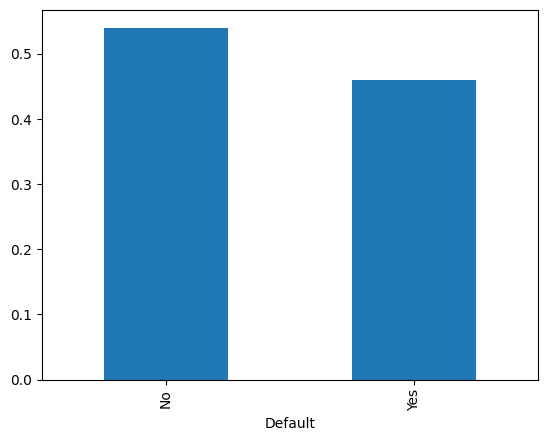

In [10]:
df['Default'].value_counts(normalize=True).plot.bar()

<Axes: >

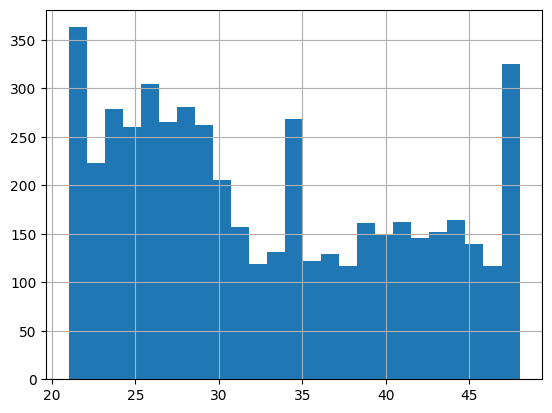

In [11]:
df['Age'].hist(bins=25)

<Axes: >

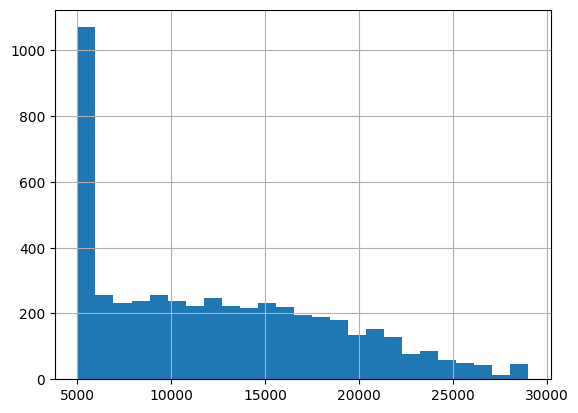

In [12]:
df['Loan_Amount_Requested'].hist(bins=25)

# Model/Pipeline Training and Selection

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer

# Features and target variable
X = df.drop(columns=['Default', 'Applicant_ID'])
y = df['Default']

numeric_features = ['Annual_Income', 'Credit_Score', 'Employment_Years', 'Loan_Amount_Requested']
categorical_features = ['Age']

numeric_transformer = Pipeline([
                                ('imputer', SimpleImputer(strategy='median')),
                                ('scaler', MinMaxScaler())
                                ])

categorical_transformer = Pipeline([
                                    ('bin', KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile')),
                                    ('encoder', OneHotEncoder(handle_unknown='ignore'))
                                   ])

preprocessor = ColumnTransformer(transformers=[
                                                ('num', numeric_transformer, numeric_features),
                                                ('cat', categorical_transformer, categorical_features)
                                                ])

model_pipe = Pipeline([
                        ('preprocessor', preprocessor),
                        ('classifier', LogisticRegression()),
                        ])

model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Annual_Income',
                                                   'Credit_Score',
                                                   'Employment_Years',
                                                   'Loan_Amount_Requested']),
                                                 ('cat',
                                                  Pipeline(steps=[('bin',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=6)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Age'])])),
                ('classifier', LogisticRegression())])

In [14]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=667)
y_pred = cross_val_predict(model_pipe, X, y, cv=cv)

In [15]:
labels = np.unique(df['Default']).tolist()
labels

['No', 'Yes']

              precision    recall  f1-score   support

          No       0.97      0.96      0.97      2702
         Yes       0.95      0.97      0.96      2298

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



Text(0.5, 1.0, 'Confusion Matrix')

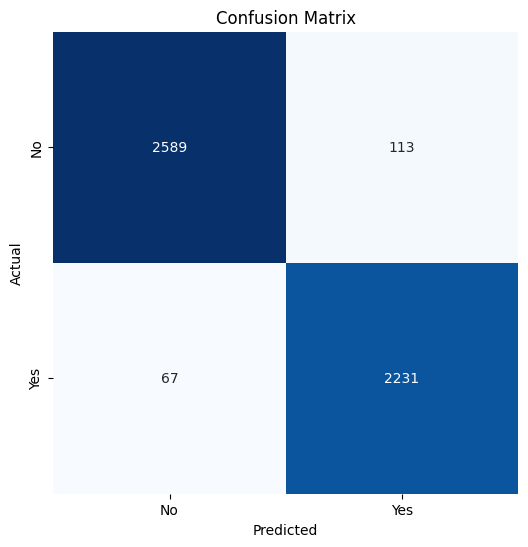

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

report = classification_report(y, y_pred)
print(report)

conf_matrix = confusion_matrix(y, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

## Fit Entire Dataset

In [17]:
model_pipe.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Annual_Income',
                                                   'Credit_Score',
                                                   'Employment_Years',
                                                   'Loan_Amount_Requested']),
                                                 ('cat',
                                                  Pipeline(steps=[('bin',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=6)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Age'])])),
                ('classifier', LogisticRegression())])

# Deployment Modelbit

In [18]:
import pandas as pd
import numpy as np

# first define function
def predict_loan_default(Age: int, Annual_Income: float, Credit_Score: int, Employment_Years: float, Loan_Amount_Requested: float)-> str:
    """
    Predict the probability of loan default using a pre-trained machine learning pipeline.

    Args:
        Age (int): Applicant's age.
        Annual_Income (float): Applicant's annual income.
        Credit_Score (int): Applicant's credit score.
        Employment_Years (float): Number of years employed.
        Loan_Amount_Requested (float): Requested loan amount.

    Returns:
        string: loan answer.
    """

    return model_pipe.predict(pd.DataFrame([[Age, Annual_Income, Credit_Score, Employment_Years, Loan_Amount_Requested]],
                                                columns = ['Age', 'Annual_Income', 'Credit_Score', 'Employment_Years', 'Loan_Amount_Requested']))

In [19]:
df.head(5)
# take the fisrt input

,Applicant_ID,Age,Annual_Income,Credit_Score,Employment_Years,Loan_Amount_Requested,Default
0,10,32,82133,689,1,10789,No
1,38,30,53172,588,3,5442,Yes
2,6,31,90000,573,4,5000,Yes
3,15,29,74634,621,7,16074,Yes
4,35,36,78232,701,5,17742,No


In [20]:
#columns = ['Age', 'Annual_Income', 'Credit_Score', 'Employment_Years', 'Loan_Amount_Requested']
predict_loan_default(32, 821233, 689, 1, 10789)

array(['No'], dtype=object)

In [21]:
mb.deploy(predict_loan_default,name='test666')

In [ ]:
## wait one minute

# Call REST API Modelbit

## Prediction: No Default

## Prediction: Default

In [23]:
#['Age', 'Annual_Income', 'Credit_Score', 'Employment_Years', 'Loan_Amount_Requested']
!curl -X POST "https://frenzfrenz.app.modelbit.com/v1/test666/latest" -d "{\"data\": [30, 53172, 588, 3, 5442]}"

{"data":["Yes"]}

In [24]:
!curl -X POST "https://frenzfrenz.app.modelbit.com/v1/test666/latest" -d "{\"data\": [32, 82133, 689, 1, 10789]}"

{"data":["No"]}

## Using JSON library

In [31]:
import requests

url = "https://frenzfrenz.app.modelbit.com/v1/test666/latest"
headers = {'Content-Type': 'application/json'}

value = [30, 53172, 588, 3, 5442]
data = {"data": value}

response = requests.post(url, headers=headers, json=data)
if response.status_code == 200:
    response_json = response.json()
    #print(response_json)
    result = response_json['data'][0]
else:
    print(f"Errore nella richiesta HTTP. Codice di stato: {response.status_code}")

result

'Yes'

## Inference Function

In [32]:
import requests

def predict_modelbit(url,input_list)-> str:
    """Function of inference"""

    headers = {'Content-Type': 'application/json'}
    data = {"data": input_list}
    response = requests.post(url, headers=headers, json=data)
    if response.status_code == 200:
        response_json = response.json()
        result = response_json['data'][0]
        return result
    else:
        print(f"Errore nella richiesta HTTP. Codice di stato: {response.status_code}")

In [33]:
modelurl = "https://frenzfrenz.app.modelbit.com/v1/test666/latest"
#value_list = [30, 53172, 588, 3, 5442] #Yes
value_list =  [32, 821233, 689, 1, 10789] #No

predict_modelbit(modelurl,value_list)

'No'

### Gradio App

In [34]:
!pip install -U gradio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 9.4 MB/s eta 0:00:00


In [35]:
import gradio as gr
import requests
import ast


def predict_modelbit(url, input_list):
    "Function of inference"
    headers = {'Content-Type': 'application/json'}
    data = {"data": input_list}
    response = requests.post(url, headers=headers, json=data)
    if response.status_code == 200:
        response_json = response.json()
        result = response_json['data'][0]
        return result
    else:
        return f"Errore nella richiesta HTTP. Codice di stato: {response.status_code}"


def predict(input_list):
    input_list = ast.literal_eval(input_list)
    return predict_modelbit(modelurl, input_list)

modelurl = "https://frenzfrenz.app.modelbit.com/v1/test666/latest"  #

input_interface = gr.Textbox(label="Input List (comma separated)")
output_interface = gr.Textbox(label="Prediction")

interface = gr.Interface(fn=predict,
                        inputs=input_interface,
                        outputs=output_interface,
                        title="ModelBit Predictor",
                        description="Enter a comma-separated list of inputs.",
                        flagging_mode ='never'
                        )

interface.launch()

#[32, 821233, 689, 1, 10789] #No
#[30, 53172, 588, 3, 5442] #Yes

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://69296609a47f48291e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
